### 1. 데이터 구하기

### 2. 기본 통계분석으로 이상치 찾기
- 데이터의 분포를 그려보기
- z-test로 정규분포를 만족하는지 확인하기
- (정규분포를 만족하지 않으면) Time series decompose 수행후 residual로 분석하기

- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이상치들을 제거/교정해야할지 내버려둘지 고민하기

### 3. Unsupervised Clustering 으로 이상치 찾기
- k-means로 분석하기
- DBSCAN으로 분석하기
- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이 이상치를 제거/교정해야할지 내버려둘지 고민하기

### 4. LSTM 오토인코더로 이상치 찾기
- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기
- 앞선 두가지 방법과 비교하기
- 다른 이유가 뭔지 확인해보기
- 더 나은 형태의 오토인코더 모델을 만들어보기

In [9]:
import requests
import os

url = "https://query1.finance.yahoo.com/v7/finance/download/NQ=F?period1=969235200&period2=1603152000&interval=1d&events=history&includeAdjustedClose=true"
response = requests.get(url)
csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/nasdaq.csv'

with open(csv_file, "w") as fp:  
    fp.write(response.text)
    
# 저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)

# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()



Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

결측치는 1072개 존재합니다.

In [10]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6166
삭제 후 데이터 길이(일자수): 5094


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### 2. 기본 통계분석으로 이상치 찾기
#### 데이터 분포

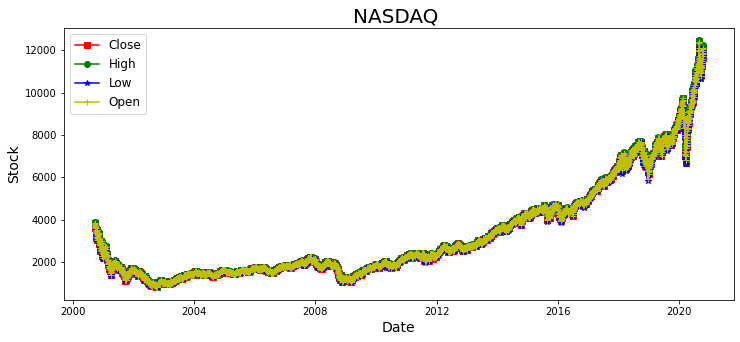

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDAQ ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

눈에 띄는 이상치는 없습니다.

#### z-test 방법

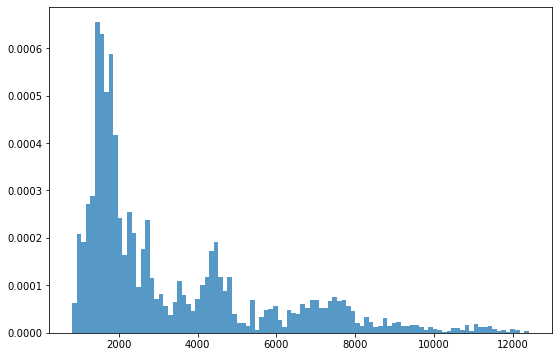

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

정규분포와는 거리가 먼 분포입니다. 단변수의 정규분포 여부를 확인하기 위해 z-test 방법을 이용합니다.

In [15]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


p가 0.05 이하인 0으로 나왔기 때문에 정규분포와는 거리가 멀다는 것을 알 수 있습니다.

#### 시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법 : Time series decomposition

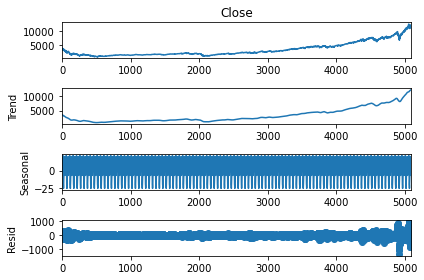

In [16]:
# 계절적 성분의 주기는 임의로 50일로 가정합니다.
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

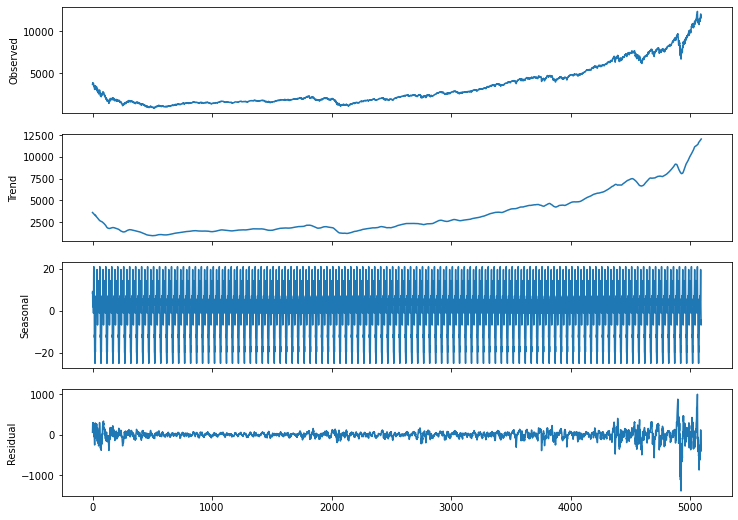

In [17]:
# 그래프를 확대합니다.

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

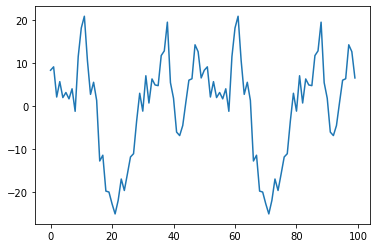

In [18]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()

#### Time series decompose 통한 Residual 분포

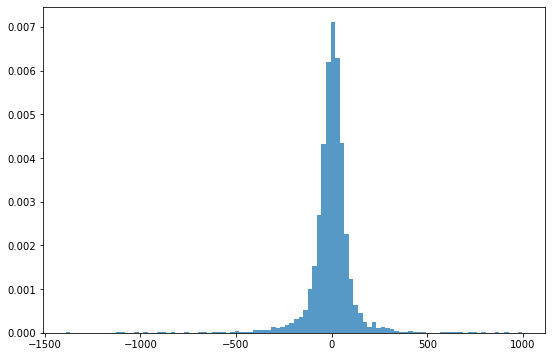

In [19]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

정규 분포로 가정할 수 있는 형태이나, z-test를 통해 숫자로 확인하겠습니다.

In [21]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8942734929026334 0.37117557875830953


p-value가 0.05 이상으로 강하게 나타나며, 이는 데이터 분포가 정규분포를 잘 따르고 있다는 뜻입니다. 따라서 정규분포로 가정하고 분석할 수 있습니다.

#### 3σ 기준 신뢰구간으로 이상치 찾기


In [22]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.3857940518773666 표준편차: 110.60068205120827
이상치 갯수: 93


93개의 이상치에 해당하는 날짜는 다음과 같습니다.

In [23]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5083   2020-10-05
5084   2020-10-06
5085   2020-10-07
5086   2020-10-08
5093   2020-10-19
Name: Date, Length: 93, dtype: datetime64[ns]

신뢰구간 방법은 하나의 지표만 활용해서 이상치를 탐색한다는 한계가 있습니다. 위 경우는 종가Close 하나의 지표만을 이용하여 93개의 이상치를 찾았으나 다른 지표별로 분석하면 더 많은 이상치가 있을 수 있습니다. 이를 극복하기 위한 방법으로 다음은 클러스터링을 이용하여 다변량 이상치 탐색을 하겠습니다.

### 3. Unsupervised Clustering 으로 이상치 찾기

#### 데이터 전처리

In [24]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,3324.303285,3355.663089,3292.204015,3326.157530,287799.978783
std,2390.871506,2412.479986,2369.858940,2394.718369,109505.690572
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.251875,1597.572500,1571.058750,1584.191100,220550.460000
50%,2263.775000,2291.211250,2231.463750,2264.287900,268829.760000
75%,4433.603750,4464.010625,4399.788125,4434.981250,319616.697500
max,12064.786259,12214.296509,11897.172140,12066.724264,776809.340000


In [25]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-1.494218,-1.447168,-1.394948,-1.402187,151.569395
std,113.106458,102.570229,117.278403,110.763008,110728.081183
min,-1280.163546,-1494.231533,-1226.595518,-1389.770659,-602995.916675
25%,-37.912202,-35.100432,-38.323649,-37.371552,-53378.364320
50%,3.575670,3.350366,4.153527,2.958782,-550.641229
75%,40.353926,37.613888,42.048756,40.813609,51586.933556
max,996.821566,933.584382,941.409836,996.232816,810709.568301


각 변수의 잔차를 살펴보면 숫자 간 큰 차이가 있습니다. 이러한 데이터를 그대로 분석에 사용하면 숫자가 큰 변수가 가장 중요하게 반영됩니다. 이를 방지하기 위해 각 변수들을 표준 정규화해줍니다.

In [26]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.49421837  -1.44716848  -1.39494753  -1.40218679 151.56939522]


array([[ 0.94173218,  0.84218124,  0.81160865,  0.59799575,  0.08320961],
       [ 0.48655464,  1.27770882,  1.3787828 ,  2.08212326,  0.10452718],
       [ 1.89305329,  2.00817542,  2.03390849,  2.72037058, -0.08886831],
       ...,
       [-0.65531897, -1.82608069, -0.96473553, -1.32833825,  0.28432658],
       [-1.31334711, -1.62375976, -0.70348768, -2.17905108, -0.36418376],
       [-2.12456827, -2.48917183, -2.57191425, -3.70655626,  0.57687603]])

#### k-means 로 이상치 탐색하기
k-means을 이용하여 정상 데이터 그룹과 이상치 데이터 그룹, 총 2개 그룹으로 나눕니다.

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [28]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1025 4069]


분석 결과 0번 그룹은 1025개의 샘플, 1번 그룹은 4069개의 샘플로 분류됐습니다. 어느 한쪽을 이상치 그룹으로 선택하기에는 너무 많이 분류됐기 때문에 그룹 숫자를 더 늘려서 분석해보겠습니다.

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1040',
 'group:1-count:74',
 'group:2-count:742',
 'group:3-count:106',
 'group:4-count:311',
 'group:5-count:397',
 'group:6-count:1046',
 'group:7-count:31',
 'group:8-count:20',
 'group:9-count:262',
 'group:10-count:438',
 'group:11-count:13',
 'group:12-count:35',
 'group:13-count:97',
 'group:14-count:482']

count가 20개 이하인 group 8과 group 11을 이상치로 분류하고 원인을 분석하겠습니다.

1. 어떤 날들이 분류된건지 탐색

In [34]:
df[(kmeans.labels_==8) | ( kmeans.labels_==11)]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


In [37]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5.094000e+03
mean,3322.800450,3354.209317,3290.797495,3324.746141,3324.746141,2.879739e+05
std,2390.480458,2411.646052,2370.093040,2394.337534,2394.337534,1.594162e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1592.812500,1608.312500,1576.500000,1593.000000,1593.000000,1.906860e+05
50%,2229.625000,2257.375000,2210.750000,2230.250000,2230.250000,2.656720e+05
75%,4445.000000,4464.687500,4417.875000,4448.250000,4448.250000,3.558778e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [36]:
# 2020-02-11 ~ 2020-02-24, 2020-03-13 ~2020-03-24, 2020-04-17 정황
df.iloc[4891:4946]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.00,9609.50,9501.25,9527.25000,9527.25000,589570.0
4892,2020-02-12,9536.25,9628.25,9523.75,9625.75000,9625.75000,454472.0
4893,2020-02-13,9621.50,9644.75,9511.25,9613.00000,9613.00000,613580.0
4894,2020-02-14,9626.25,9659.25,9588.00,9632.25000,9632.25000,489387.0
4895,2020-02-16,9635.00,9668.75,9634.25,9663.75000,9663.75000,297278.0
4896,2020-02-18,9635.00,9687.50,9534.25,9636.00000,9636.00000,668505.0
4897,2020-02-19,9643.25,9748.75,9641.25,9733.50000,9733.50000,419130.0
4898,2020-02-20,9744.75,9763.00,9517.00,9624.25000,9624.25000,802424.0
4899,2020-02-21,9617.25,9623.75,9411.50,9458.00000,9458.00000,911839.0
4900,2020-02-23,9355.25,9365.00,9289.00,9315.00000,9315.00000,995989.0


#### 2. 각 그룹은 어떤 특징을 갖고 있는지

In [38]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,0.208734,0.210396,0.265769,0.249790,-0.406729
1,-1.553192,-1.667173,-2.103025,-2.062452,2.750833
2,0.352775,0.382333,0.291303,0.306922,0.506777
3,2.293611,2.380824,2.415479,2.376406,-0.438564
4,-0.186571,-0.213582,-0.418386,-0.402497,1.528749
5,-0.413290,-0.462715,-0.328959,-0.369733,-0.960155
6,-0.191460,-0.191263,-0.182387,-0.178142,0.219125
7,-4.262138,-4.603683,-4.243449,-4.319169,0.501229
8,6.027197,6.084572,6.079186,6.001044,-0.221431
9,0.259411,0.254501,0.316326,0.305125,-1.922633


- 8번 그룹은 Open, High, Low, Close의 값이 유독 높은 그룹입니다.
- 11번 그룹은 Open, High, Low, Close의 값이 유독 낮은 그룹입니다.

#### 왜 이상치로 분류된걸까?

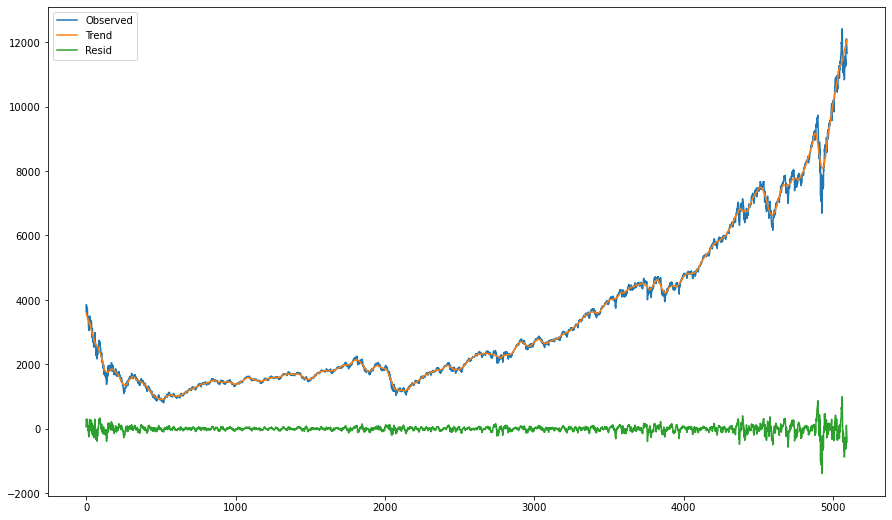

In [39]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

- 실제 나스닥 데이터를 확인한 결과 2020 3월 중순에 증시 대폭락이 있었고, 8월 말에서 9월 초 사이에 급상승이 있었습니다.

#### DBSCAN 으로 이상치 찾기

In [40]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [41]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  0 ...  0 -1 -1]


In [42]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:196',
 'group:0-count:4839',
 'group:1-count:3',
 'group:2-count:12',
 'group:3-count:2',
 'group:4-count:2',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:2',
 'group:21-count:3',
 'group:22-count:2',
 'group:23-count:2']

### 4. LSTM 오토인코더로 이상치 찾기

In [44]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [46]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [47]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [48]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [49]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [50]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
158/159 [============================>.] - ETA: 0s - loss: 2.1783 - mae: 2.1783
Epoch 00001: val_loss improved from inf to 0.78421, saving model to /home/aiffel0047/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 5s 29ms/step - loss: 2.1682 - mae: 2.1682 - val_loss: 0.7842 - val_mae: 0.7842
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 0.4913 - mae: 0.4913
Epoch 00002: val_loss improved from 0.78421 to 0.66358, saving model to /home/aiffel0047/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 4s 28ms/step - loss: 0.4913 - mae: 0.4913 - val_loss: 0.6636 - val_mae: 0.6636
Epoch 3/50
159/159 [==============================] - ETA: 0s - loss: 0.4071 - mae: 0.4071
Epoch 00003: val_loss did not improve from 0.66358
159/159 [==============================] - 4s 28ms/step - loss: 0.4071 - mae: 0.4071 - val_loss: 0.9531 - val_mae: 0.9531
Epoch 4/50
159/159 [============================

In [51]:
model.load_weights(checkpoint_path)

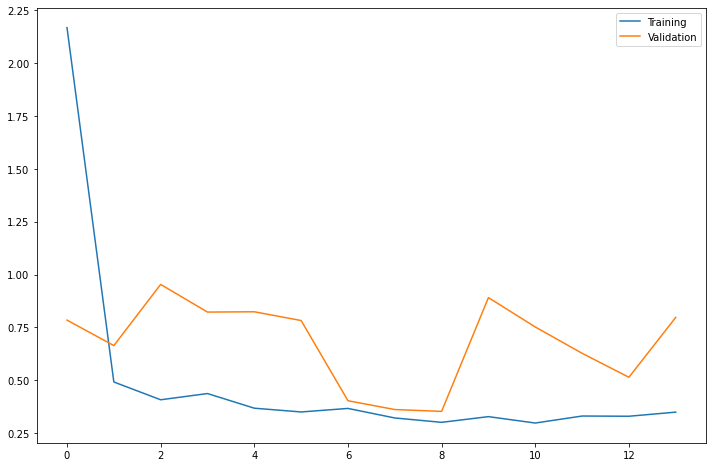

In [52]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

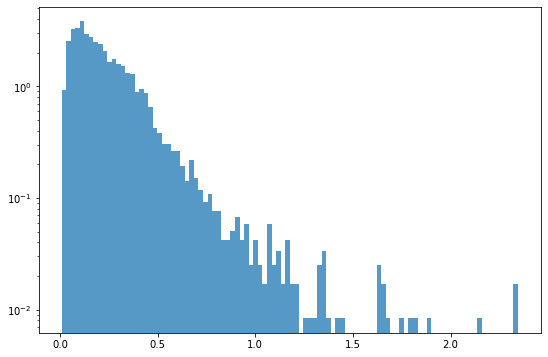

In [53]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

#### mae_loss 기준치 변경

In [58]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1.5
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4532,2018-10-11,7010.25,7138.00,6907.750000,7031.000000,7031.000000,1146270.0,1.633165
4892,2020-02-25,9091.00,9224.25,8810.000000,8854.250000,8854.250000,1344897.0,1.793662
4893,2020-02-26,8868.25,9037.50,8709.500000,8850.250000,8850.250000,1251412.0,1.647336
4894,2020-02-27,8811.50,8878.50,8334.250000,8382.750000,8382.750000,1580041.0,2.344629
4895,2020-02-28,8347.00,8574.75,8126.250000,8454.000000,8454.000000,1527204.0,2.342575
4896,2020-03-01,8347.00,8574.75,8126.250000,8382.750000,8382.750000,1513887.0,2.136077
4897,2020-03-02,8349.25,8883.25,8224.250000,8791.250000,8791.250000,1373357.0,1.748331
4898,2020-03-03,8830.50,9002.50,8511.000000,8582.500000,8582.500000,1295648.0,1.664986
4920,2020-03-29,7395.75,7507.25,7367.250000,7489.250000,7489.250000,1256384.0,1.634293
4930,2020-04-12,8296.00,8327.50,8073.250000,8115.750000,8115.750000,1224003.0,1.879950


In [59]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
0,2000-10-02,3621.000000,3668.000000,3492.000000,3528.500000,3528.500000,63100.0,0.461745
1,2000-10-03,3529.000000,3603.000000,3385.000000,3397.000000,3397.000000,78732.0,0.534180
2,2000-10-04,3426.500000,3477.500000,3334.000000,3477.500000,3477.500000,77551.0,0.562157
3,2000-10-05,3460.500000,3537.000000,3431.500000,3482.500000,3482.500000,69864.0,0.471846
4,2000-10-06,3490.000000,3509.500000,3305.000000,3357.500000,3357.500000,69256.0,0.499787
...,...,...,...,...,...,...,...,...
5076,2020-10-08,11473.200195,11578.799805,11469.799805,11539.000000,11539.000000,403379.0,0.333978
5077,2020-10-09,11562.000000,11739.000000,11552.500000,11724.799805,11724.799805,408445.0,0.331615
5078,2020-10-12,11722.799805,12197.000000,11687.799805,12098.200195,12098.200195,756438.0,0.567619
5079,2020-10-13,12100.000000,12249.000000,12019.000000,12094.000000,12094.000000,754735.0,0.640466


/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


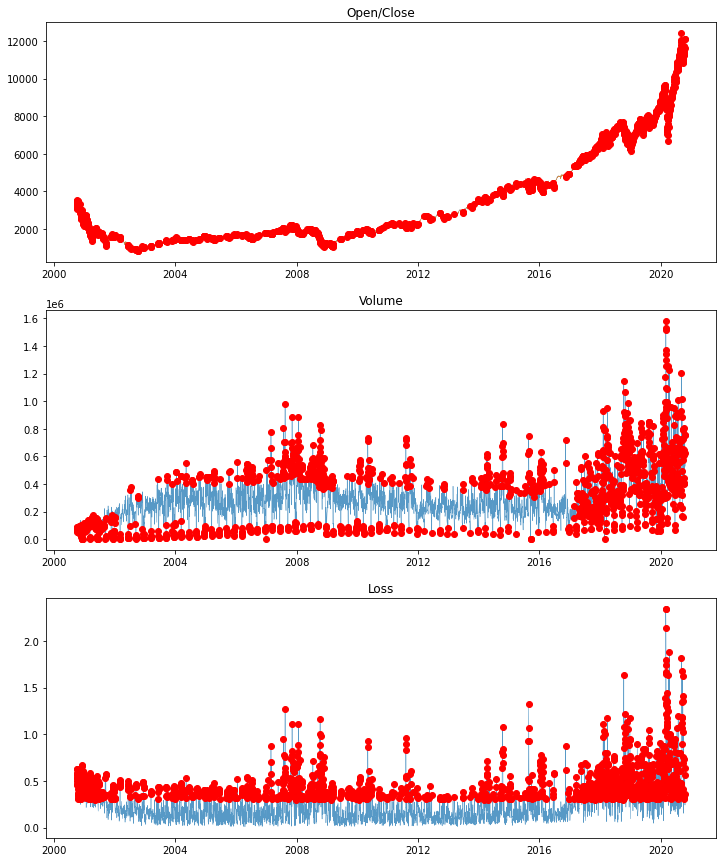

In [60]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])